# Albums-CV. "Определение жанра по изображению обложки музыкального диска"

## Подготовка к работе

Загрузим нужные библиотеки

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms, models, datasets
from torchvision.models import resnet50, ResNet50_Weights

import faiss
from PIL import Image

from IPython.display import Markdown, display
import warnings
import os
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

## Загрузка и просмотр изображений

Создадим класс `CustomImageDataset`, в котором пропишем чтение файлов из папок и стандартные методы `__len__` и `__getitem__`.

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None):
        
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_folder = {}
        
        path = "../data/"
        folders = ["anime", "classical", "black metal", 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']

        for label, folder in enumerate(folders):
            folder_path = f'{path}{folder}'
            for filename in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, filename))
                self.labels.append(label)
                self.label_to_folder[label] = folder

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        label = torch.tensor(self.labels[idx])
        return img, label

Построим по одному изображению из каждого альбома.

In [4]:
dataset = CustomImageDataset(transform=transforms.ToTensor())

In [5]:
folders = list(set(dataset.label_to_folder.values()))

random_indices = []

for folder in folders:
    indices_from_folder = [idx for idx, label in enumerate(dataset.labels) if dataset.label_to_folder[label] == folder]
    random_index = random.choice(indices_from_folder)
    random_indices.append(random_index)



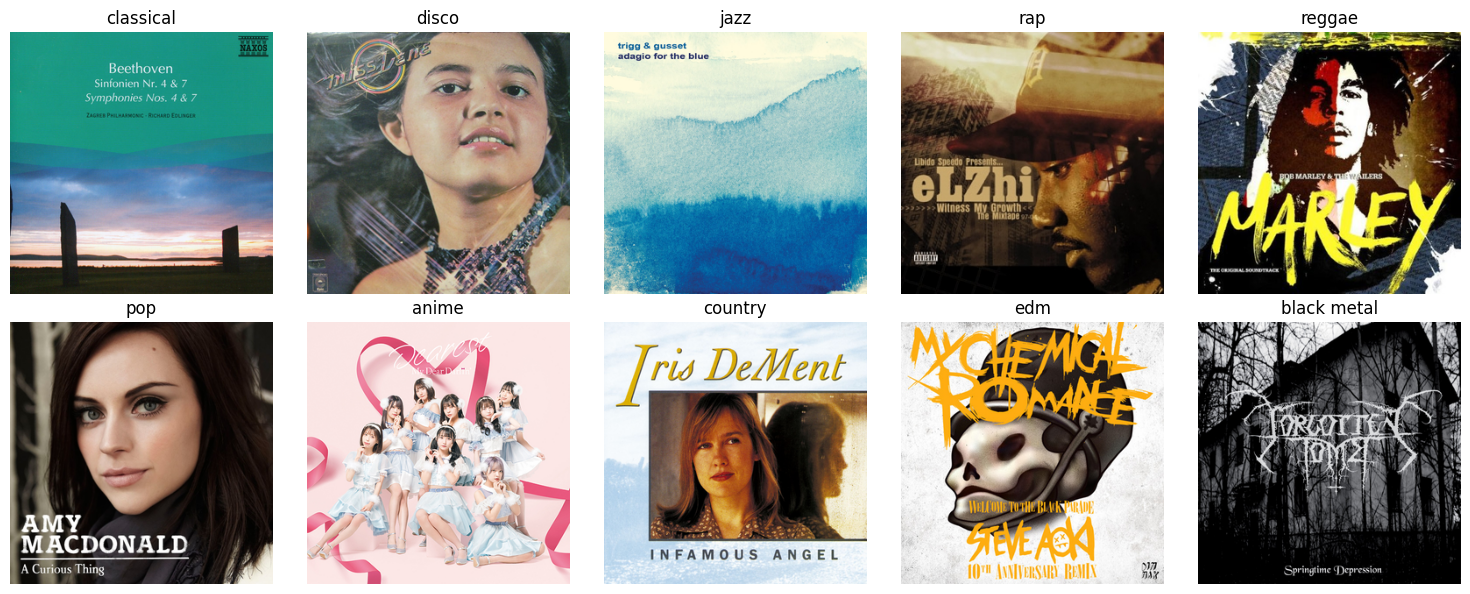

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image, label = dataset[idx]
    label_name = dataset.label_to_folder[label.item()]

    image = image.permute(1, 2, 0)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(label_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Изображения выглядят читабельно. Посмотрим на дисбаланс классов.

In [7]:
def show_class_imbalance(dataset):
    class_counts = {label: 0 for label in dataset.label_to_folder.keys()}
    
    for label in dataset.labels:
        class_counts[label] += 1
    
    total_samples = len(dataset)
    
    for label, count in class_counts.items():
        folder_name = dataset.label_to_folder[label]
        percentage = (count / total_samples) * 100
        display(Markdown(f"Класс **{folder_name}** с меткой {label} содержит {class_counts[label]} объектов, что составляет **{percentage:.2f}%** от всех данных"))

In [8]:
show_class_imbalance(CustomImageDataset())

Класс **anime** с меткой 0 содержит 1189 объектов, что составляет **15.24%** от всех данных

Класс **classical** с меткой 1 содержит 955 объектов, что составляет **12.24%** от всех данных

Класс **black metal** с меткой 2 содержит 450 объектов, что составляет **5.77%** от всех данных

Класс **country** с меткой 3 содержит 1486 объектов, что составляет **19.05%** от всех данных

Класс **disco** с меткой 4 содержит 468 объектов, что составляет **6.00%** от всех данных

Класс **edm** с меткой 5 содержит 719 объектов, что составляет **9.22%** от всех данных

Класс **jazz** с меткой 6 содержит 821 объектов, что составляет **10.53%** от всех данных

Класс **pop** с меткой 7 содержит 803 объектов, что составляет **10.29%** от всех данных

Класс **rap** с меткой 8 содержит 328 объектов, что составляет **4.21%** от всех данных

Класс **reggae** с меткой 9 содержит 581 объектов, что составляет **7.45%** от всех данных

Присутсвует значительный дисбаланс. Приступим к бэйзлайну.

## Бэйзлайн

### Получение эмбеддингов

Для получения эмбеддингов нужно предобработать изображения:
1. Измени размер изображений на 224х224
2. Преобразуем изображение в тензор
3. Используем стандартные параметры нормализации изображений

In [9]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Создадим датасет и передадим его в даталоадер

In [10]:
dataset = CustomImageDataset(transform=transform)

Data_loader = DataLoader(dataset, batch_size=32)

Создадим класс `ResNetEncoder`, в который передадим предобученную модель `ResNet50` с весами `ResNet50_Weights.IMAGENET1K_V2`, убрав последний слой, который используется для классификации объектов.

In [11]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        original_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(original_resnet.children())[:-1])

    def forward(self, x):
        return self.features(x)

Переведём модель в режим оценки.

In [12]:
model = ResNetEncoder()
model.eval()

ResNetEncoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

Проверим доступность `cuda`.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Получим эмбеддинги, сохранив их.

In [14]:
save_path = 'embeddings_data.pth'

try:
    print('Загружаем сохранённые эмбеддинги')
    data = torch.load(save_path)
    embeddings_to_FAISS = data['embeddings']
    labels_all = data['labels']

except:
    print('Получаем эмбеддинги')
    embeddings_to_FAISS = []
    labels_all = []

    model = model.to(device)
    
    for images, labels in tqdm(Data_loader):
        images = images.to(device)
        labels = labels.to(device)

        embeddings = model(images)
        batch_size, num_features, _, _ = embeddings.size()
        embeddings_flat = embeddings.view(batch_size, num_features)
        labels = labels.view(-1, 1) 
        
        for i in range(batch_size):
            embedding_np = embeddings_flat[i].detach().cpu().numpy()
            embeddings_to_FAISS.append(embedding_np)
            labels_all.append(labels[i].item())
            
    torch.save({'embeddings': embeddings_to_FAISS, 'labels': labels_all}, save_path)

Загружаем сохранённые эмбеддинги


Эмбеддинги готовы к передаче в `FAISS`.

### FAISS

In [15]:
d = 2048
index = faiss.IndexFlatL2(d)

In [16]:
embeddings_np = np.array(embeddings_to_FAISS)
index.add(embeddings_np)

In [17]:
k = 10
D, I = index.search(embeddings_np, k)

print(I)

[[   0  419  492 ...  877  293  291]
 [   1 4240  626 ...  218  754 3419]
 [   2  421  331 ...   89  233  496]
 ...
 [7797 3351 2883 ... 2936 4060 7567]
 [7798 7447   92 ... 7758 7338 1836]
 [7799 5514 7520 ... 1390 5635 3911]]


In [18]:
FAISS_pred = []

for i in range(len(I)):
    FAISS_pred.append(labels_all[I[i][1]])

FAISS_pred = np.array(FAISS_pred)

In [19]:
f1_score(labels_all, FAISS_pred, average='macro')

0.46972175444895825

Получена стартовая метрика на бейзлане. Попробуем классифицировать с помощью `ResNet50`.

## ResNet50

### Базовая модель

Создадим `train_loader` и `test_loader`, выделив 20% выборки для тестирования. При этом используем `StratifiedShuffleSplit`, так как присутсвует дисбаланс классов.

In [20]:
test_size = 0.2

labels_list = [label for _, label in dataset]

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_STATE)
train_indices, test_indices = next(stratified_split.split(labels_list, labels_list))

train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(test_indices))

Проверим дисбаланс.

In [21]:
train_labels = []

for _, label in train_loader:
    train_labels.extend(label.tolist())

In [22]:
class_counts = Counter(train_labels)
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[0])
total_samples = sum(class_counts.values())
sorted_class_counts_with_percentages = [(class_label, count, round(count/total_samples*100, 2)) for class_label, count in sorted_class_counts]

sorted_class_counts_with_percentages

[(0, 951, 15.24),
 (1, 764, 12.24),
 (2, 360, 5.77),
 (3, 1189, 19.05),
 (4, 375, 6.01),
 (5, 575, 9.21),
 (6, 657, 10.53),
 (7, 642, 10.29),
 (8, 262, 4.2),
 (9, 465, 7.45)]

Дисбаланс соблюден. Создадим модель `model_base` на основе `resnet50` с весами `ResNet50_Weights.IMAGENET1K_V2`, изменив последний слой для классификации 10 классов. Если есть сохранённая модель и история её обучения, то используем эти данные.

In [23]:
num_classes = 10
model_base = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_base.fc.in_features
model_base.fc = nn.Linear(num_ftrs, num_classes)
model_base.to(device)

try:
    checkpoint = torch.load('model_losses_f1.pth')
    model_base.load_state_dict(checkpoint['model_state_dict'])
    losses_base = checkpoint['losses']
    f1_base = checkpoint['f1_scores']

    print('Загружена обученная модель')
    flag = 'pretrained'
    
except:
    print('Обучаем модель')
    flag = 'train'

Загружена обученная модель


Создадим функцию для обучения и валидации модели на каждой эпохе.

In [24]:
def train_valid(model, train_loader, test_loader, optimizer, criterion, num_epochs=20):

    num_classes=10
    
    losses = []
    f1_scores = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    
        model.eval()
        with torch.no_grad():
            y_true = []
            y_pred = []
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
            
            f1_macro = f1_score(y_true, y_pred, average='macro')
            f1_scores.append(f1_macro)
            print(f'Эпоха {epoch+1}: f1_macro на тестовой выборке: {f1_macro}')



    return model, losses, f1_scores

Обучим модель с функцией потерь `CrossEntropyLoss` и оптимизатором `SGD`.

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

In [26]:
if flag == 'train':
    model_base, losses_base, f1_base  = train_valid(model_base, train_loader, test_loader, optimizer, criterion)

    torch.save({
    'model_state_dict': model_base.state_dict(),
    'losses': losses_base,
    'f1_scores': f1_base
    }, 'model_losses_f1.pth')

Построим графики обучения.

In [27]:
def graphs(losses, f1):
    
    epoch_losses = []
    total_loss = 0

    for i in range(0, len(losses), len(train_loader)):
        epoch_loss = sum(losses[i:i+len(train_loader)])
        epoch_losses.append(epoch_loss/len(train_loader))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(range(len(losses_base)), losses_base, label='Individual Losses')
    axs[0].plot(list(range(len(train_loader), len(losses_base)+len(train_loader), len(train_loader))), epoch_losses, label='Epoch Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, len(f1)+1), f1)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Test f1_macro')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    f1_max = max(f1)

    display(Markdown(f'Максимальная метрика при обучении **{f1_max:.4f}** на **{f1.index(f1_max)}** эпохе'))
    display(Markdown(f'Метрика модели после {len(f1)} эпох **{f1[-1]:.4f}**'))

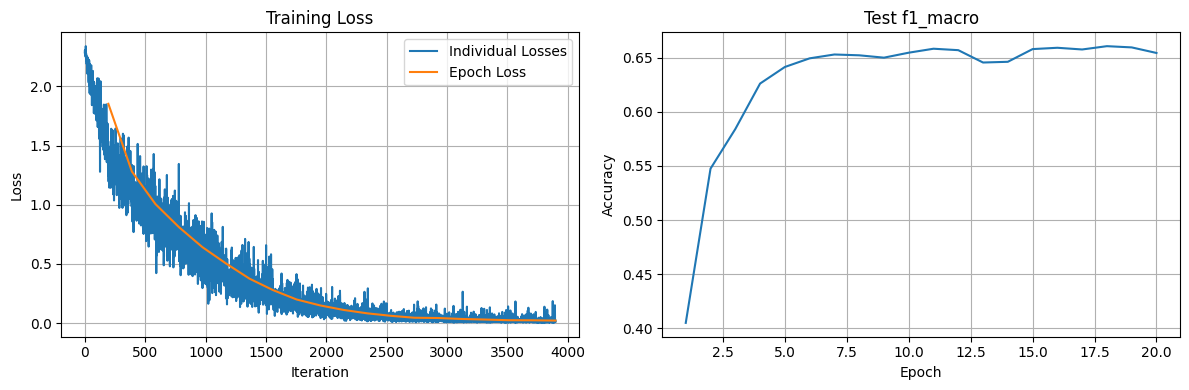

Максимальная метрика при обучении **0.6606** на **17** эпохе

Метрика модели после 20 эпох **0.6543**

In [28]:
graphs(losses_base, f1_base)

Используем оптимизатор `ADAM`.

## ADAM

In [29]:
model_ADAM = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_ADAM.fc.in_features
model_ADAM.fc = nn.Linear(num_ftrs, num_classes)
model_ADAM.to(device)

optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(), lr=0.001)

try:
    checkpoint_ADAM = torch.load('model_losses_f1_ADAM.pth')
    model_ADAM.load_state_dict(checkpoint_ADAM['model_state_dict'])
    losses_ADAM = checkpoint_ADAM['losses']
    f1_ADAM = checkpoint_ADAM['f1_scores']

    print('Загружена обученная модель')
    flag = 'pretrained'

except:
    print('Обучаем модель')
    flag = 'train'

Загружена обученная модель


In [30]:
if flag == 'train':
    model_ADAM, losses_ADAM, f1_ADAM  = train_valid(model_ADAM, train_loader, test_loader, optimizer_ADAM, criterion)
    
    torch.save({
    'model_state_dict': model_ADAM.state_dict(),
    'losses': losses_ADAM,
    'f1_scores': f1_ADAM
    }, 'model_losses_f1_ADAM.pth')

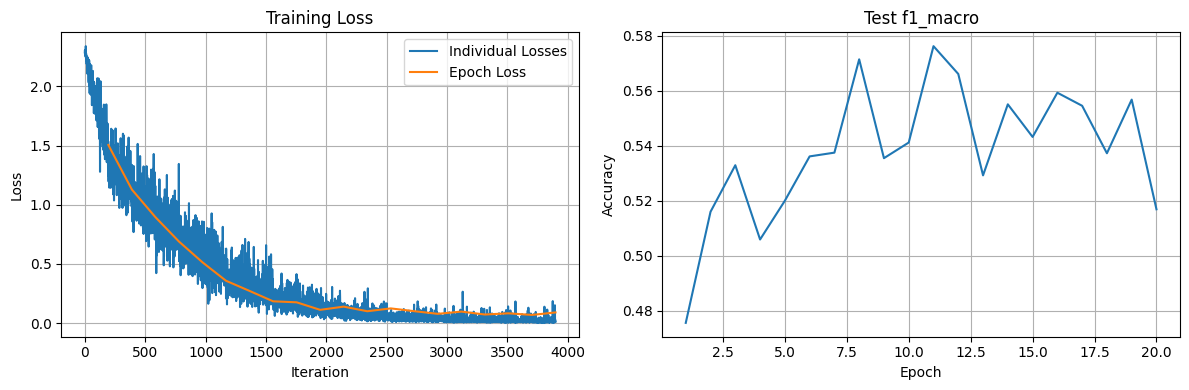

Максимальная метрика при обучении **0.5762** на **10** эпохе

Метрика модели после 20 эпох **0.5169**

In [31]:
graphs(losses_ADAM, f1_ADAM)

Изменим архитектуру, добавив промежуточный слой между основной нейросетью и слоём-классификатором.

## fc

In [32]:
model_fc = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

fc_layer = nn.Linear(2048, 256)
additional_layer = nn.Linear(256, 32)
new_classifier = nn.Linear(32, num_classes)
model_fc.fc = nn.Sequential(fc_layer, nn.ReLU(), additional_layer, nn.ReLU(), new_classifier)

model_fc.to(device)

optimizer = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9)

In [33]:
try:
    checkpoint_fc = torch.load('model_losses_f1_fc.pth')
    model_fc.load_state_dict(checkpoint_fc['model_state_dict'])
    losses_fc = checkpoint_fc['losses']
    f1_fc = checkpoint_fc['f1_scores']

    print('Загружена обученная модель')
    flag = 'pretrained'

except:

    print('Обучаем модель')
    flag = 'train'

Загружена обученная модель


In [34]:
if flag == 'train':
    model_fc, losses_fc, f1_fc  = train_valid(model_fc, train_loader, test_loader, optimizer, criterion)

    torch.save({
    'model_state_dict': model_fc.state_dict(),
    'losses': losses_fc,
    'f1_scores': f1_fc
    }, 'model_losses_f1_fc.pth')

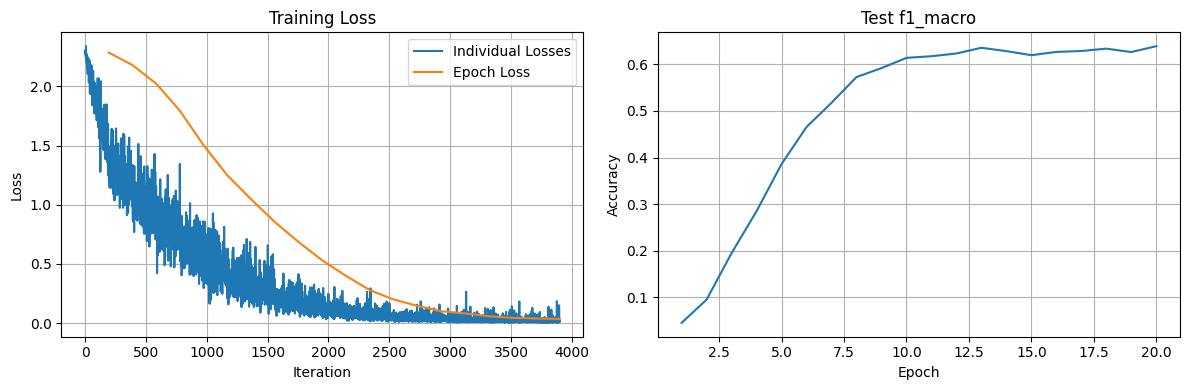

Максимальная метрика при обучении **0.6391** на **19** эпохе

Метрика модели после 20 эпох **0.6391**

In [35]:
graphs(losses_fc, f1_fc)

Обучим модель с указанием весов для каждого класса.

## class_weights

In [36]:
from collections import defaultdict

class_counts = defaultdict(int)

for _, label in dataset:
    class_counts[label.item()] += 1

class_counts

defaultdict(int,
            {0: 1189,
             1: 955,
             2: 450,
             3: 1486,
             4: 468,
             5: 719,
             6: 821,
             7: 803,
             8: 328,
             9: 581})

In [37]:
total_samples = sum(class_counts.values())
class_weights = [total_samples / (num_classes * count) for count in class_counts.values()]

class_weights

[0.656013456686291,
 0.8167539267015707,
 1.7333333333333334,
 0.5248990578734859,
 1.6666666666666667,
 1.0848400556328233,
 0.9500609013398295,
 0.9713574097135741,
 2.3780487804878048,
 1.342512908777969]

In [38]:
class_weights_tensor = torch.tensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion.to(device)

CrossEntropyLoss()

In [39]:
model_cw = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_cw.fc.in_features
model_cw.fc = nn.Linear(num_ftrs, num_classes)
    
model_cw.to(device)

optimizer = optim.SGD(model_cw.parameters(), lr=0.001, momentum=0.9)

In [40]:
try:
    checkpoint_cw = torch.load('model_losses_f1_cw.pth')
    model_cw.load_state_dict(checkpoint_cw['model_state_dict'])
    losses_cw = checkpoint_cw['losses']
    f1_cw = checkpoint_cw['f1_scores']

    print('Загружена обученная модель')
    flag = 'pretrained'

except:

    print('Обучаем модель')
    flag = 'train'

Загружена обученная модель


In [41]:
if flag == 'train':
    model_cw, losses_cw, f1_cw = train_valid(model_cw, train_loader, test_loader, optimizer, criterion)

    torch.save({
    'model_state_dict': model_cw.state_dict(),
    'losses': losses_cw,
    'f1_scores': f1_cw
    }, 'model_losses_f1_cw.pth')

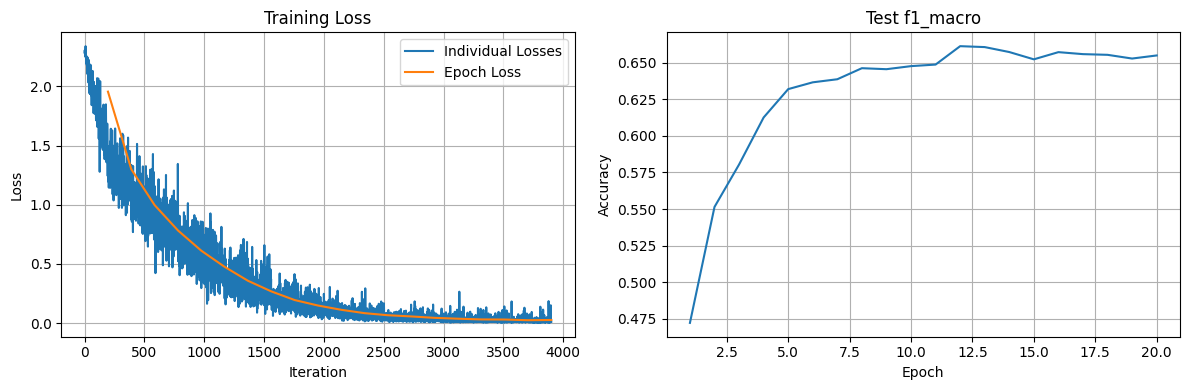

Максимальная метрика при обучении **0.6613** на **11** эпохе

Метрика модели после 20 эпох **0.6549**

In [42]:
graphs(losses_cw, f1_cw)

Лучшая модель по итоговой метрике после 20 эпох обучения: модель с весами `model_cw`.

## Анализ предсказаний лучшей модели

In [43]:
model_cw.eval()
with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cw(images)
        _, predicted = torch.max(outputs, 1)
                
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [44]:
def confusion_matrix_heatmap(y_real, y_pred, dataset, normalize=False):

    """
    Функция построения heatmap матрицы ошибок
    """

    y_real_labels = [dataset.label_to_folder[label] for label in y_real]
    y_pred_labels = [dataset.label_to_folder[label] for label in y_pred]
    labels = set(y_real_labels)

    plt.figure(figsize=(7, 5))
    plt.xlabel("Предсказанные значения", fontsize=14)
    plt.ylabel("Реальные значения", fontsize=14)
    plt.title("Матрица ошибок", fontsize=18)

    if normalize:
        mcm = confusion_matrix(y_real_labels, y_pred_labels, normalize='true')
        sns.heatmap(
        mcm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    else:
        mcm = confusion_matrix(y_real_labels, y_pred_labels)
        sns.heatmap(
        mcm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )


    plt.show()

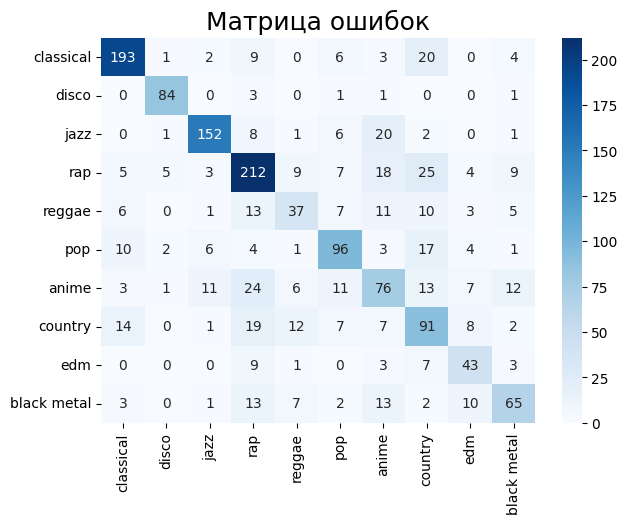

In [45]:
confusion_matrix_heatmap(y_test, y_pred, dataset)

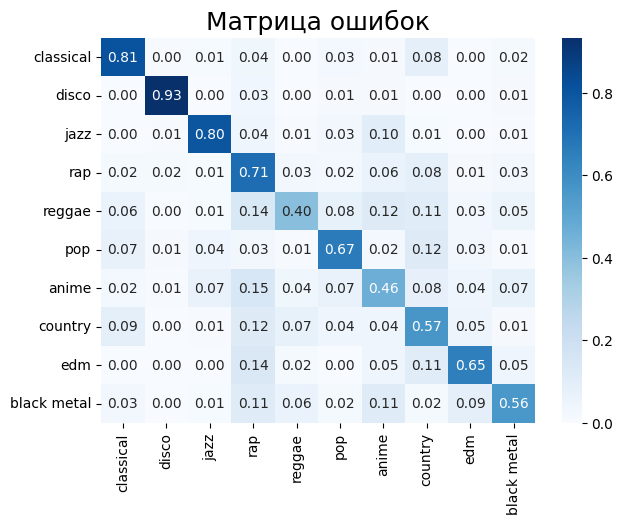

In [46]:
confusion_matrix_heatmap(y_test, y_pred, dataset, normalize=True)

In [47]:
labels = [dataset.label_to_folder[label] for label in dataset.label_to_folder]

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       anime       0.82      0.81      0.82       238
   classical       0.86      0.80      0.83       191
 black metal       0.89      0.93      0.91        90
     country       0.68      0.71      0.69       297
       disco       0.50      0.40      0.44        93
         edm       0.67      0.67      0.67       144
        jazz       0.49      0.46      0.48       164
         pop       0.49      0.57      0.52       161
         rap       0.54      0.65      0.59        66
      reggae       0.63      0.56      0.59       116

    accuracy                           0.67      1560
   macro avg       0.66      0.66      0.65      1560
weighted avg       0.67      0.67      0.67      1560



Хуже всего модель разделяет `pop`, `jazz` и `edm`.

## Выводы

Разрботан классификатор обложек музыкальных альбомов с `f1_macro` **0.6549** на основе `ResNet50` с передачей весов классов в `criterion`.
К улучшению:
1. Попробовать классический `ML`.
2. Применить `FastAi`.
3. Обернуть решение в `Streamlit`.